In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Datasets used:
- Exterior temperature of the past 5 months (december to may) at the coordinates 41.50N 2.11E (faculty of enginyeri) which is 133m over the sea so the temperature is from the 120m in that coordinates.
- Sensors placed on the classes, we will focus on the temperature inside the class, using it as the y value.

## Preparing the data

### Limpieza de los datasets

In [14]:
# Load data from CSV and cleaning it
sensors_data = pd.read_csv('hourly_sensor_data.csv')
sensors_data[['Date', 'Hour']] = sensors_data['Hour'].str.split(' ', expand=True)
sensors_data['Date'] = pd.to_datetime(sensors_data['Date'])
sensors_data['Hour'] = pd.to_datetime(sensors_data['Hour'])
sensors_data['Hour'] = sensors_data['Hour'].dt.time
outside_data = pd.read_csv('open-meteo-41.50N2.11E133m.csv')
outside_data = outside_data.iloc[2:] #deleting first two rows
outside_data = outside_data.iloc[:, :2] #keeping the first two columns
outside_data.columns = ['dia', 'hora']
outside_data['dia'] = pd.to_datetime(outside_data['dia'])
outside_data['fecha'] = outside_data['dia'].dt.date
outside_data['temperatura'] = outside_data['hora']
outside_data['hora'] = outside_data['dia'].dt.time
del outside_data['dia']
outside_data = outside_data[['fecha', 'hora', 'temperatura']]

sensors_data = sensors_data.rename(columns={'Hour': 'hour', 'Date': 'date', 'location': 'location', 'Sensor': 'sensor', 'Average Hourly Value': 'average value'})
outside_data = outside_data.rename(columns={'hora': 'hour', 'fecha': 'date', 'temperatura': 'temperature'})

print(sensors_data)
print(outside_data)


# inside_unique_days = sensors_data['day'].nunique()
# outside_unique_days = outside_data['fecha'].nunique()
# print("Número de días únicos:", inside_unique_days, outside_unique_days)

<ipython-input-14-a6a0329851fc>:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sensors_data['Hour'] = pd.to_datetime(sensors_data['Hour'])


                 location      hour       sensor  average value       date
0       am3019-testqc2090  14:00:00          co2     464.750000 2023-07-25
1       am3019-testqc2090  14:00:00     humidity      36.000000 2023-07-25
2       am3019-testqc2090  14:00:00  temperature      27.875000 2023-07-25
3       am3019-testqc2090  15:00:00          co2     458.833333 2023-07-25
4       am3019-testqc2090  15:00:00     humidity      35.333333 2023-07-25
...                   ...       ...          ...            ...        ...
114699       q4-1003-7456  11:00:00     humidity      39.833333 2024-03-30
114700       q4-1003-7456  11:00:00  temperature      21.616667 2024-03-30
114701       q4-1003-7456  12:00:00          co2     430.666667 2024-03-30
114702       q4-1003-7456  12:00:00     humidity      38.333333 2024-03-30
114703       q4-1003-7456  12:00:00  temperature      22.350000 2024-03-30

[114704 rows x 5 columns]
            date      hour  temperature
2     2023-12-10  02:00:00       

### Creación columnas CO2, temperature, humidity

In [20]:
# Pivotar el DataFrame sensors_data para tener cada sensor como una columna
sensors_pivot = sensors_data.pivot_table(index=['date', 'location', 'hour'], columns='sensor', values='average value')

# Resetear el índice para que 'day' y 'location' se conviertan en columnas
sensors_pivot.reset_index(inplace=True)

# Renombrar las columnas para que coincidan con lo que quieres
sensors_pivot.rename(columns={'co2': 'co2', 'humidity': 'humidity', 'temperature': 'temperature'}, inplace=True)

# Mostrar el DataFrame pivotado
print(sensors_pivot)

# Filtrar filas con valores NaN en las columnas 'co2', 'humidity' y 'temperature'
nan_rows = sensors_pivot[sensors_pivot[['co2', 'humidity', 'temperature']].isna().any(axis=1)]

# Mostrar las filas con valores NaN
print(nan_rows)


sensor       date           location      hour         co2   humidity  \
0      2023-07-25  am3019-testqc2090  14:00:00  464.750000  36.000000   
1      2023-07-25  am3019-testqc2090  15:00:00  458.833333  35.333333   
2      2023-07-25  am3019-testqc2090  16:00:00  481.400000  34.900000   
3      2023-07-25  am3019-testqc2090  17:00:00  486.166667  35.916667   
4      2023-07-25  am3019-testqc2090  18:00:00  461.666667  34.416667   
...           ...                ...       ...         ...        ...   
38247  2024-03-30       q4-1003-7456  08:00:00  408.666667  40.750000   
38248  2024-03-30       q4-1003-7456  09:00:00  404.666667  40.500000   
38249  2024-03-30       q4-1003-7456  10:00:00  407.666667  40.083333   
38250  2024-03-30       q4-1003-7456  11:00:00  438.500000  39.833333   
38251  2024-03-30       q4-1003-7456  12:00:00  430.666667  38.333333   

sensor  temperature  
0         27.875000  
1         27.933333  
2         26.520000  
3         25.866667  
4         25.

### Separación de datasets en función de la ubicación

In [21]:
# Filtrar y crear dataset para 'am3019-testqc2090'
openLab_Laser_Room_data = sensors_pivot[sensors_pivot['location'] == 'am3019-testqc2090'].copy()
del openLab_Laser_Room_data['location']

# Filtrar y crear dataset para 'am307-9074'
computer_room_data = sensors_pivot[sensors_pivot['location'] == 'am307-9074'].copy()
del computer_room_data['location']

# Filtrar y crear dataset para 'eui-24e124128c147204'
digitalLab_data = sensors_pivot[sensors_pivot['location'] == 'eui-24e124128c147204'].copy()
del digitalLab_data['location']

# Filtrar y crear dataset para 'eui-24e124128c147444'
biblio_de_filosofia_y_lletres_data = sensors_pivot[sensors_pivot['location'] == 'eui-24e124128c147444'].copy()
del biblio_de_filosofia_y_lletres_data['location']

# Filtrar y crear dataset para 'eui-24e124128c147446'
# Agrega el nombre correspondiente a la ubicación
nombre_eui_24e124128c147446_data = sensors_pivot[sensors_pivot['location'] == 'eui-24e124128c147446'].copy()
del nombre_eui_24e124128c147446_data['location']

# Filtrar y crear dataset para 'eui-24e124128c147470'
# Agrega el nombre correspondiente a la ubicación
nombre_eui_24e124128c147470_data = sensors_pivot[sensors_pivot['location'] == 'eui-24e124128c147470'].copy()
del nombre_eui_24e124128c147470_data['location']

# Filtrar y crear dataset para 'eui-24e124128c147499'
audioLab_data = sensors_pivot[sensors_pivot['location'] == 'eui-24e124128c147499'].copy()
del audioLab_data['location']

print("openLab_Laser_Room_data:")
print(openLab_Laser_Room_data)

print("\ncomputer_room_data:")
print(computer_room_data)

print("\ndigitalLab_data:")
print(digitalLab_data)

print("\nbiblio_de_filosofia_y_lletres_data:")
print(biblio_de_filosofia_y_lletres_data)

print("\nnombre_eui_24e124128c147446_data:")
print(nombre_eui_24e124128c147446_data)

print("\nnombre_eui_24e124128c147470_data:")
print(nombre_eui_24e124128c147470_data)

print("\naudioLab_data:")
print(audioLab_data)


openLab_Laser_Room_data:
sensor       date      hour         co2   humidity  temperature
0      2023-07-25  14:00:00  464.750000  36.000000    27.875000
1      2023-07-25  15:00:00  458.833333  35.333333    27.933333
2      2023-07-25  16:00:00  481.400000  34.900000    26.520000
3      2023-07-25  17:00:00  486.166667  35.916667    25.866667
4      2023-07-25  18:00:00  461.666667  34.416667    25.233333
...           ...       ...         ...        ...          ...
38143  2024-03-30  08:00:00  432.600000  39.000000    21.860000
38144  2024-03-30  09:00:00  434.833333  38.916667    21.900000
38145  2024-03-30  10:00:00  435.666667  38.500000    21.916667
38146  2024-03-30  11:00:00  473.000000  38.166667    21.966667
38147  2024-03-30  12:00:00  463.200000  36.500000    22.740000

[5442 rows x 5 columns]

computer_room_data:
sensor       date      hour         co2   humidity  temperature
10     2023-07-25  14:00:00  430.000000  37.000000    27.475000
11     2023-07-25  15:00:00  421.

### Datasets organized by ubication and a counter of the NaN values

In [22]:
inside_data = [
    openLab_Laser_Room_data,
    computer_room_data,
    digitalLab_data,
    biblio_de_filosofia_y_lletres_data,
    nombre_eui_24e124128c147446_data,
    nombre_eui_24e124128c147470_data,
    audioLab_data
]

# Para imprimir todos los DataFrames dentro de inside_data
for data in inside_data:
    print(data)
    print()
    nan_count = data.isna().sum()
    print("NaN count for", data.index.name, ":", nan_count)
    print()

print(outside_data)
# Contar los valores NaN en outside_data
nan_count_outside = outside_data.isna().sum()

# Mostrar el número de valores NaN en outside_data
print("NaN count in outside_data:")
print(nan_count_outside)


sensor       date      hour         co2   humidity  temperature
0      2023-07-25  14:00:00  464.750000  36.000000    27.875000
1      2023-07-25  15:00:00  458.833333  35.333333    27.933333
2      2023-07-25  16:00:00  481.400000  34.900000    26.520000
3      2023-07-25  17:00:00  486.166667  35.916667    25.866667
4      2023-07-25  18:00:00  461.666667  34.416667    25.233333
...           ...       ...         ...        ...          ...
38143  2024-03-30  08:00:00  432.600000  39.000000    21.860000
38144  2024-03-30  09:00:00  434.833333  38.916667    21.900000
38145  2024-03-30  10:00:00  435.666667  38.500000    21.916667
38146  2024-03-30  11:00:00  473.000000  38.166667    21.966667
38147  2024-03-30  12:00:00  463.200000  36.500000    22.740000

[5442 rows x 5 columns]

NaN count for None : sensor
date           0
hour           0
co2            0
humidity       0
temperature    0
dtype: int64

sensor       date      hour         co2   humidity  temperature
10     2023-07-

### Fusión de los dos datasets en uno solo

In [36]:
# We are working with inside_data and outside_data
# Lista de nombres originales de los datasets
inside_data_names = [
    'Laser_Room',
    'Computer_Room',
    'DigitalLab',
    'Biblio_de_filosofia_y_lletres',
    'Nombre_eui_24e124128c147446',
    'Nombre_eui_24e124128c147470',
    'AudioLab'
]

merged_datasets = {}  # Diccionario para almacenar los datasets fusionados

for data_name, data in zip(inside_data_names, inside_data):
    # Fusionar el dataset interior con outside_data
    merged_data = pd.merge(data, outside_data, on=['date', 'hour'], how='inner')

    # Renombrar la columna de temperatura del outside_data
    merged_data.rename(columns={'temperature': 'outside_temperature'}, inplace=True)

    # Establecer el nombre del dataset fusionado
    merged_datasets[data_name] = merged_data

for data_name, data in zip(inside_data_names, inside_data):
    # Fusionar el dataset interior con outside_data
    merged_data = pd.merge(data, outside_data, on=['date', 'hour'], how='inner', suffixes=('_inside', '_outside'))

    # Renombrar la columna de temperatura del outside_data
    merged_data.rename(columns={'temperature_inside': 'inside_temperature', 'temperature_outside': 'outside_temperature'}, inplace=True)

    # Establecer el nombre del dataset fusionado
    merged_datasets[data_name] = merged_data

# Imprimir los datasets fusionados
for name, data in merged_datasets.items():
    print(name)
    print(data)
    print()



Laser_Room
           date      hour         co2   humidity  inside_temperature  \
0    2023-12-10  02:00:00  455.833333  36.500000           21.066667   
1    2023-12-10  03:00:00  451.500000  36.500000           21.000000   
2    2023-12-10  04:00:00  450.166667  36.500000           20.916667   
3    2023-12-10  05:00:00  453.333333  36.500000           20.816667   
4    2023-12-10  06:00:00  452.333333  36.500000           20.766667   
...         ...       ...         ...        ...                 ...   
2426 2024-03-30  08:00:00  432.600000  39.000000           21.860000   
2427 2024-03-30  09:00:00  434.833333  38.916667           21.900000   
2428 2024-03-30  10:00:00  435.666667  38.500000           21.916667   
2429 2024-03-30  11:00:00  473.000000  38.166667           21.966667   
2430 2024-03-30  12:00:00  463.200000  36.500000           22.740000   

      outside_temperature  
0                    12.4  
1                    12.5  
2                    12.4  
3           

In [37]:
# Para cada conjunto de datos fusionado en merged_datasets
for dataset_name, merged_data in merged_datasets.items():
    # Calcular el recuento de valores NaN
    nan_count = merged_data.isna().sum()

    # Imprimir el nombre del conjunto de datos fusionado y el recuento de NaNs
    print("Dataset:", dataset_name)
    print("NaN count:")
    print(nan_count)
    print()


Dataset: Laser_Room
NaN count:
date                   0
hour                   0
co2                    0
humidity               0
inside_temperature     0
outside_temperature    0
dtype: int64

Dataset: Computer_Room
NaN count:
date                   0
hour                   0
co2                    0
humidity               0
inside_temperature     0
outside_temperature    0
dtype: int64

Dataset: DigitalLab
NaN count:
date                   0
hour                   0
co2                    0
humidity               0
inside_temperature     0
outside_temperature    0
dtype: int64

Dataset: Biblio_de_filosofia_y_lletres
NaN count:
date                   0
hour                   0
co2                    0
humidity               0
inside_temperature     0
outside_temperature    0
dtype: int64

Dataset: Nombre_eui_24e124128c147446
NaN count:
date                    0
hour                    0
co2                    17
humidity                0
inside_temperature      0
outside_temperature 

## Visualizations

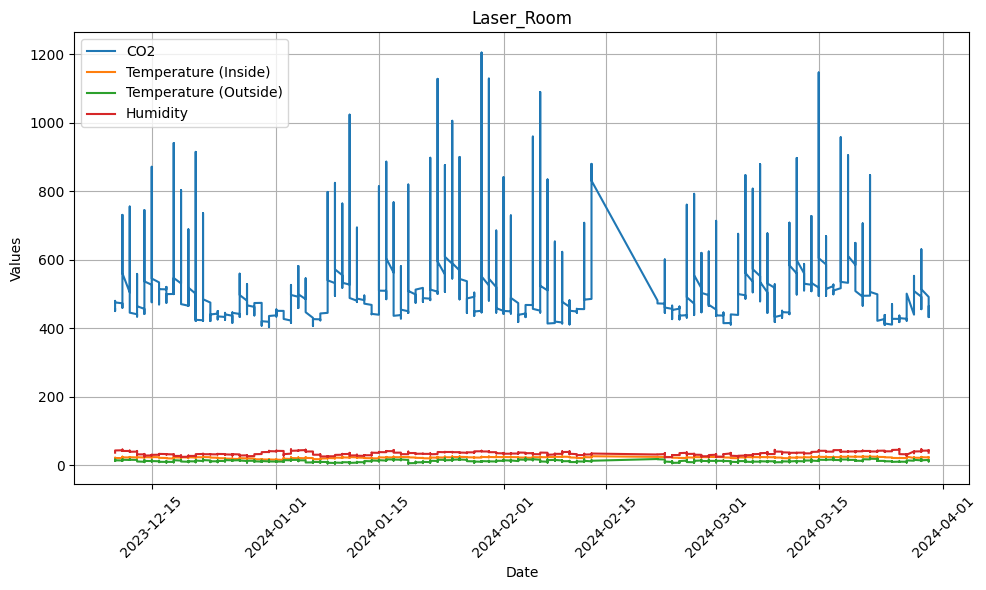

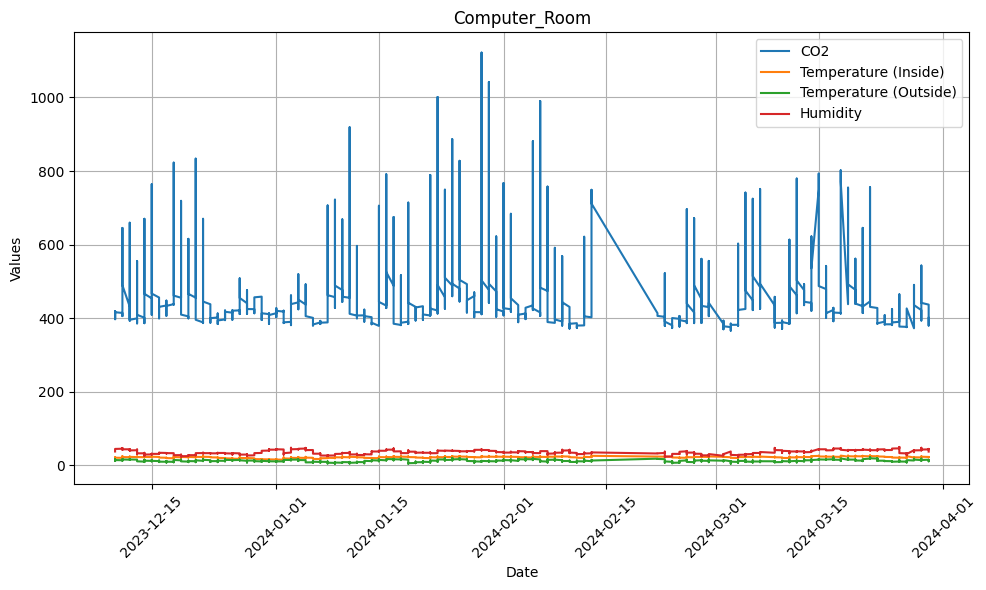

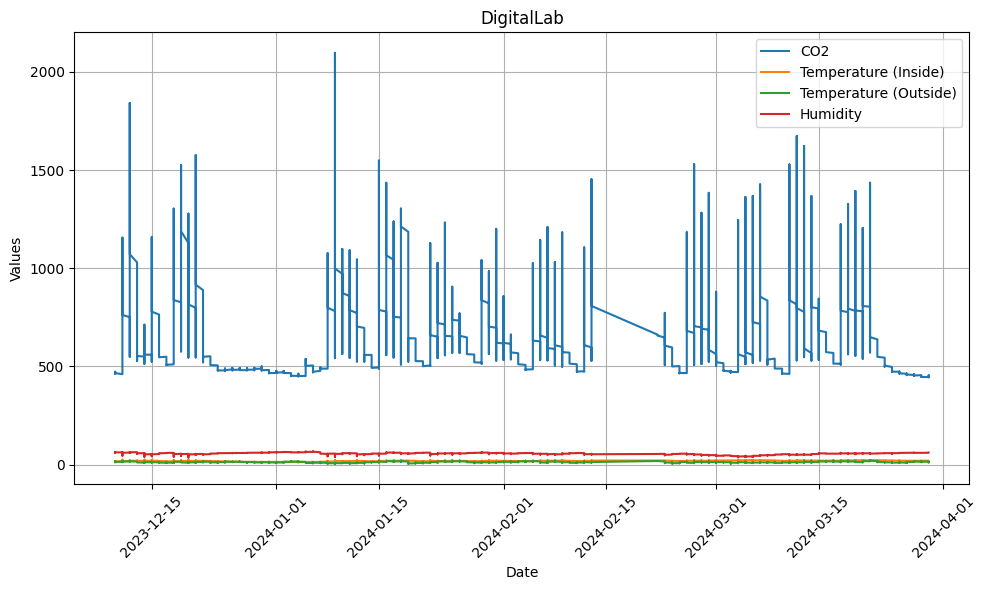

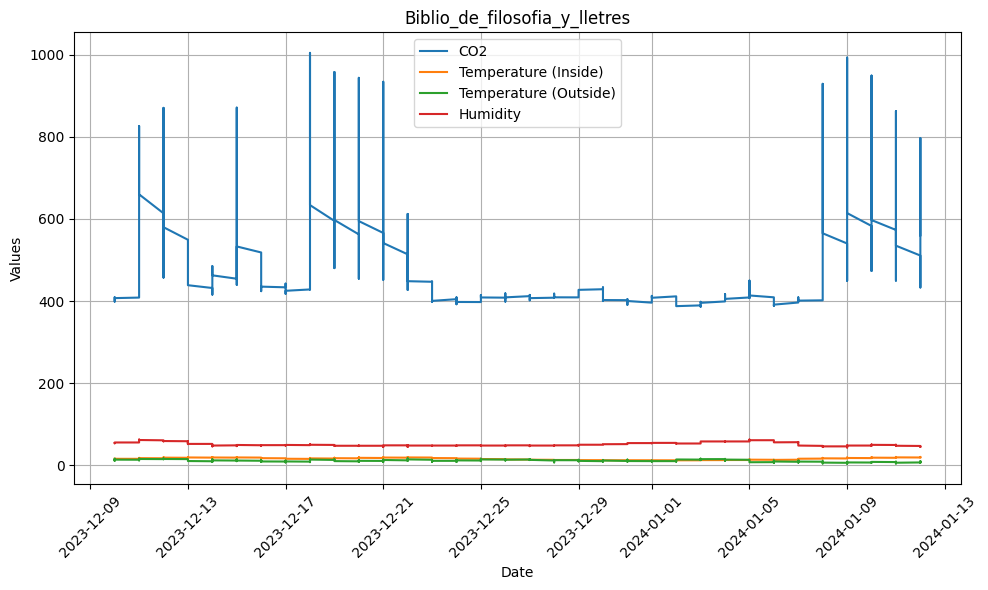

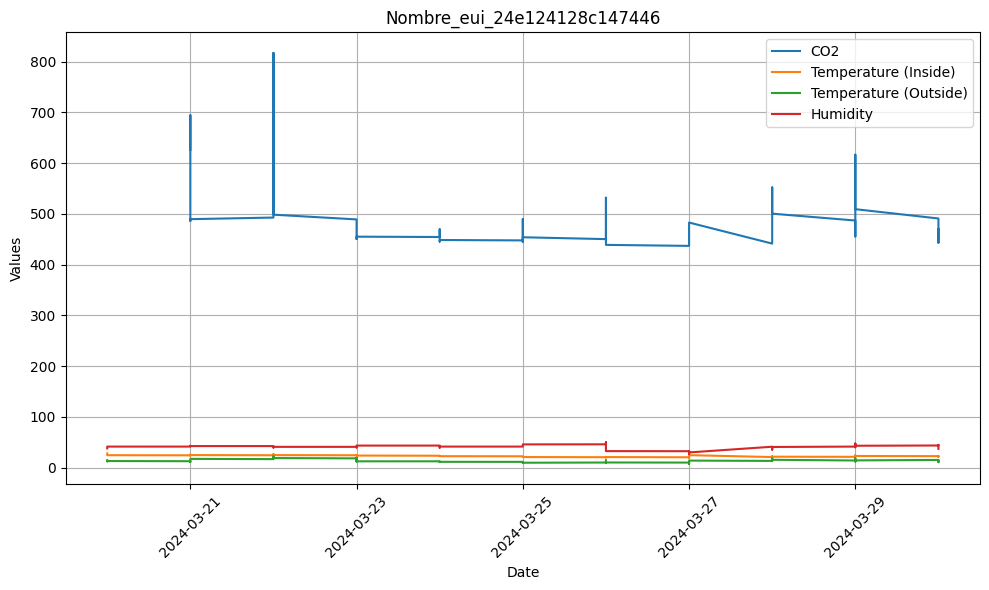

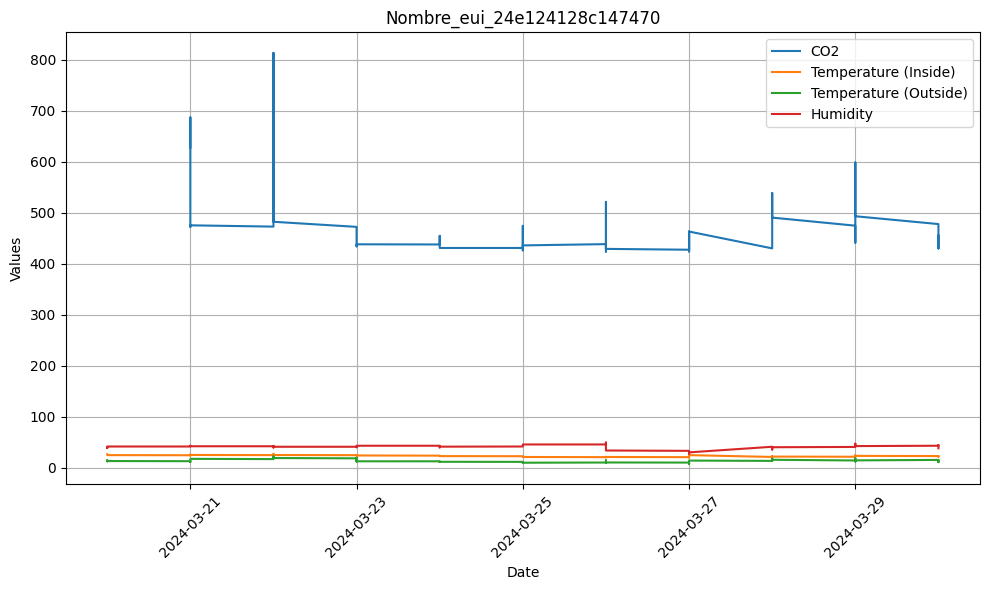

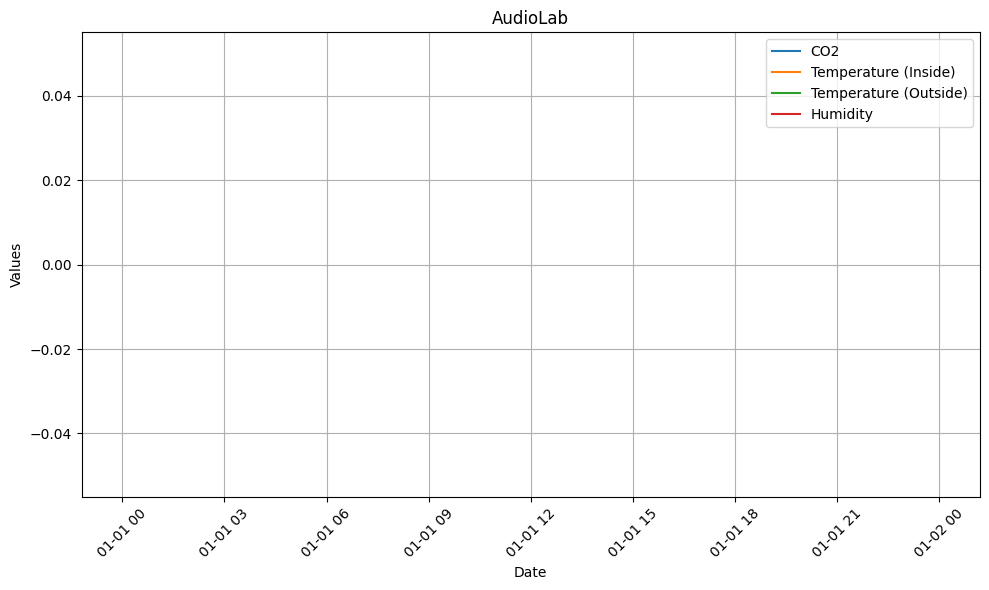

In [52]:
import matplotlib.pyplot as plt

# Recorrer cada conjunto de datos fusionado en merged_datasets
for name, data in merged_datasets.items():
    # Crear una nueva figura
    plt.figure(figsize=(10, 6))

    # Graficar el CO2, la temperatura interior, la temperatura exterior y la humedad
    plt.plot(data['date'], data['co2'], label='CO2')
    plt.plot(data['date'], data['inside_temperature'], label='Temperature (Inside)')
    plt.plot(data['date'], data['outside_temperature'], label='Temperature (Outside)')
    plt.plot(data['date'], data['humidity'], label='Humidity')

    # Configurar etiquetas y título
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.title(name)

    # Rotar las etiquetas del eje x para que sean legibles
    plt.xticks(rotation=45)

    # Agregar leyenda
    plt.legend()

    # Mostrar la gráfica
    plt.grid(True)
    plt.tight_layout()
    plt.show()


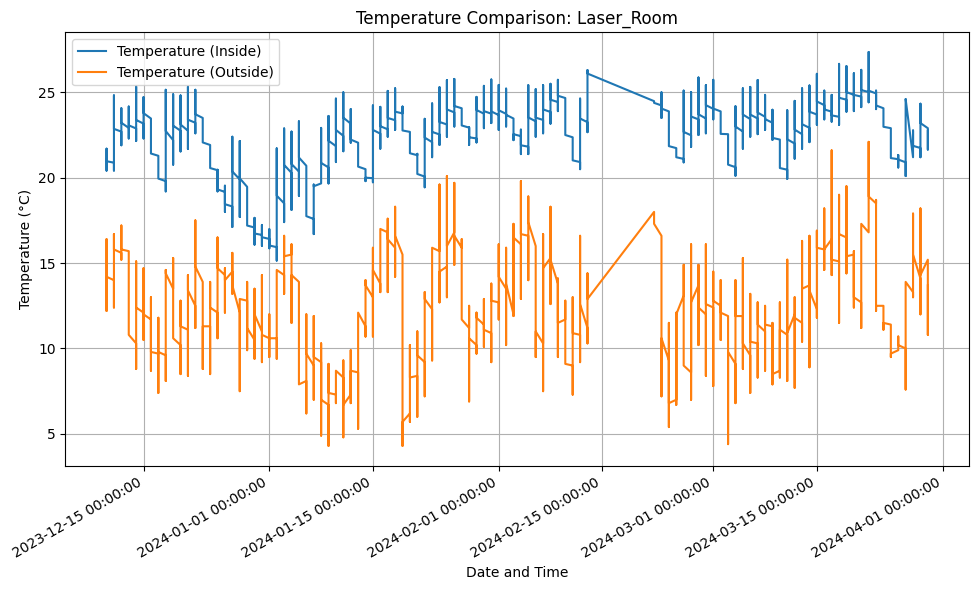

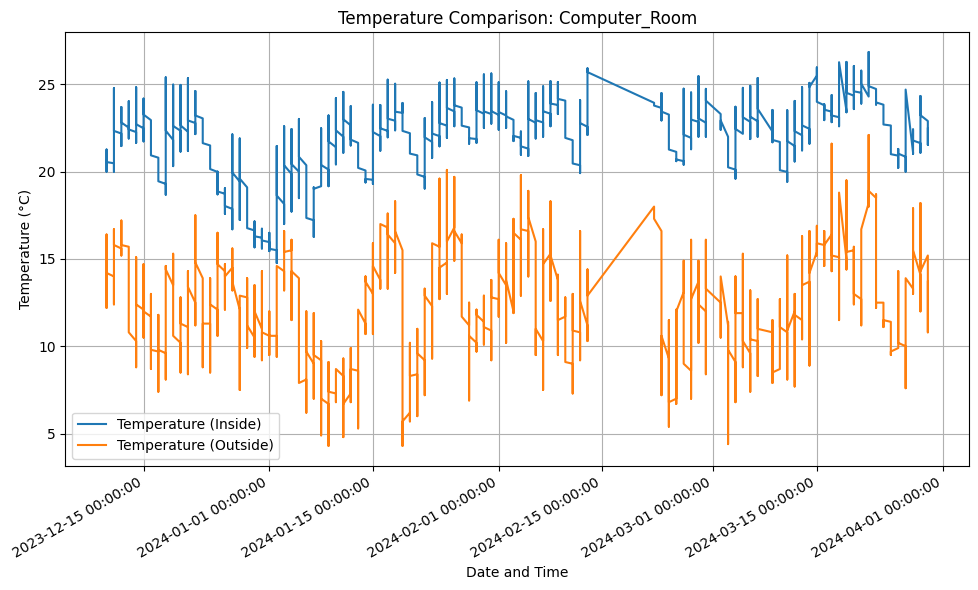

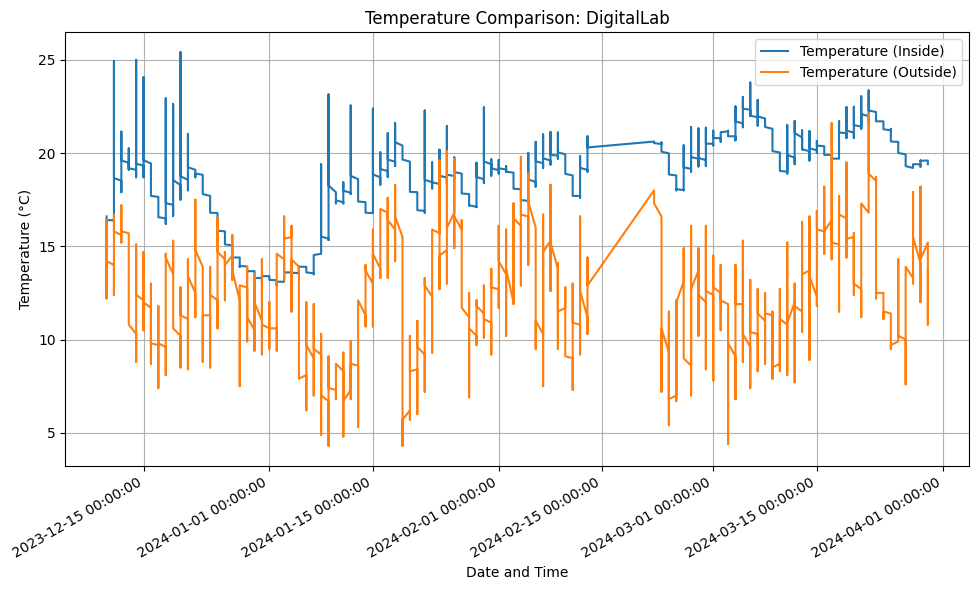

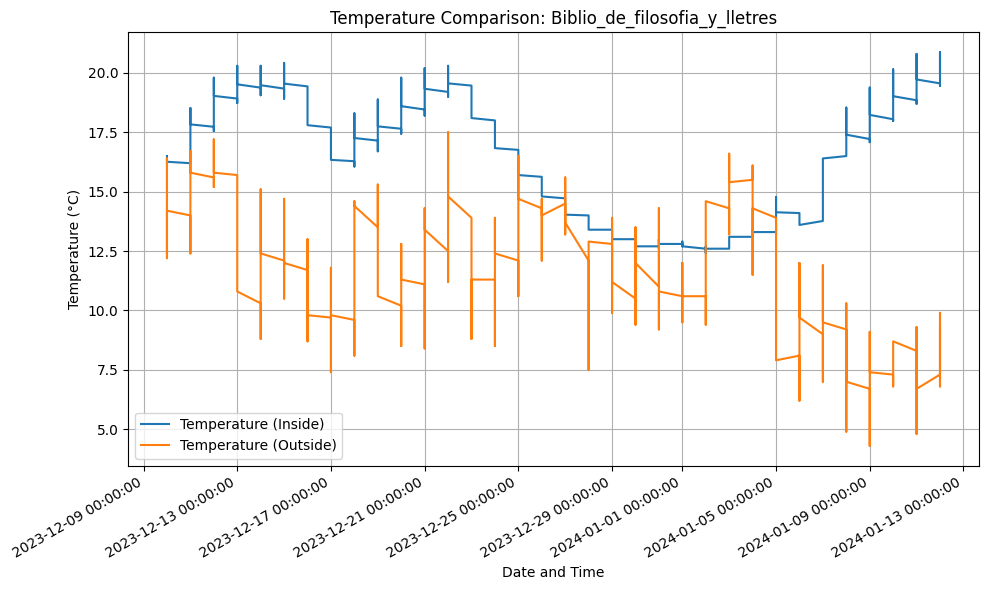

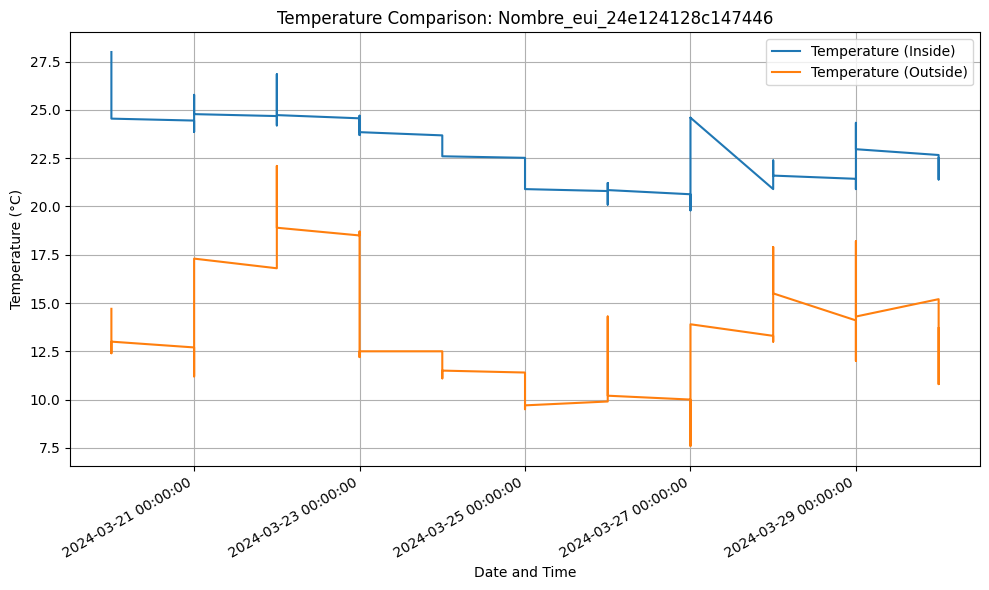

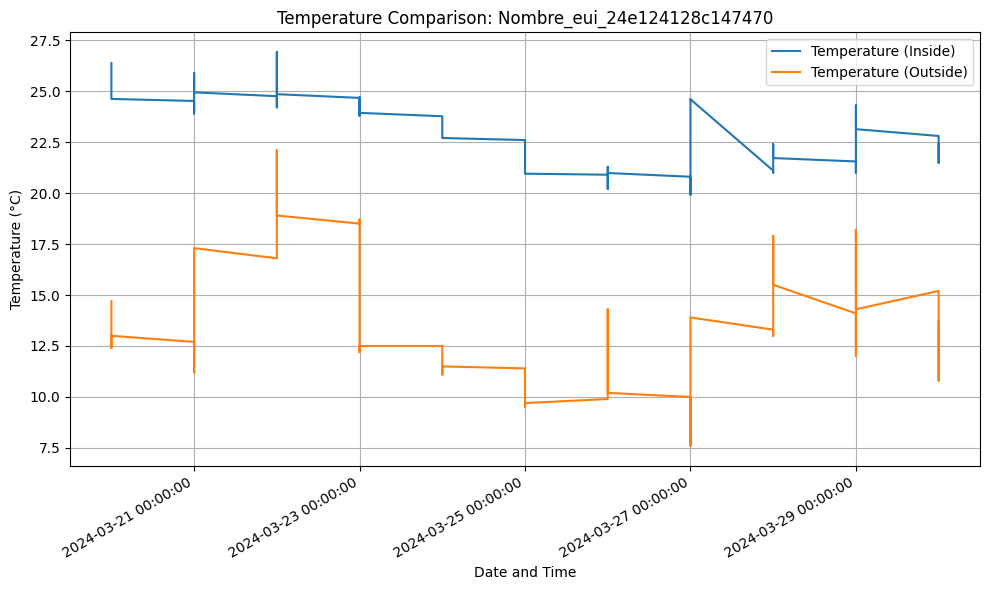

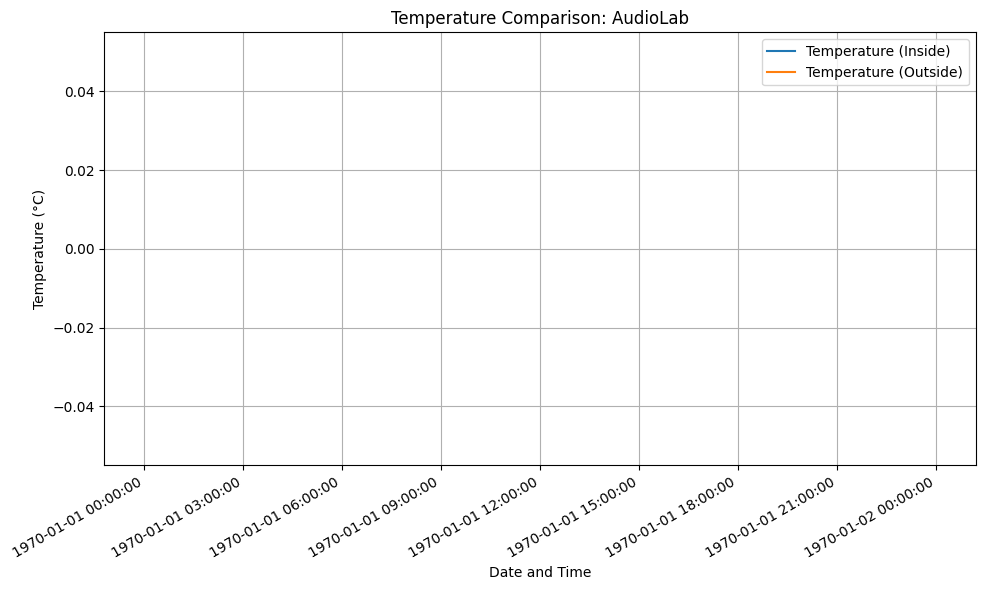

In [51]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Recorrer cada conjunto de datos fusionado en merged_datasets
for name, data in merged_datasets.items():
    # Crear una nueva figura
    plt.figure(figsize=(10, 6))

    # Graficar la temperatura interior y exterior
    plt.plot(data['date'], data['inside_temperature'], label='Temperature (Inside)')
    plt.plot(data['date'], data['outside_temperature'], label='Temperature (Outside)')

    # Configurar etiquetas y título
    plt.xlabel('Date and Time')
    plt.ylabel('Temperature (°C)')
    plt.title(f'Temperature Comparison: {name}')

    # Rotar las etiquetas del eje x para que sean legibles
    plt.xticks(rotation=45)

    # Formatear las etiquetas del eje x para incluir fecha y hora
    date_format = DateFormatter("%Y-%m-%d %H:%M:%S")
    plt.gca().xaxis.set_major_formatter(date_format)

    # Ajustar el espaciado entre las etiquetas del eje x
    plt.gcf().autofmt_xdate()

    # Agregar leyenda
    plt.legend()

    # Mostrar la gráfica
    plt.grid(True)
    plt.tight_layout()
    plt.show()


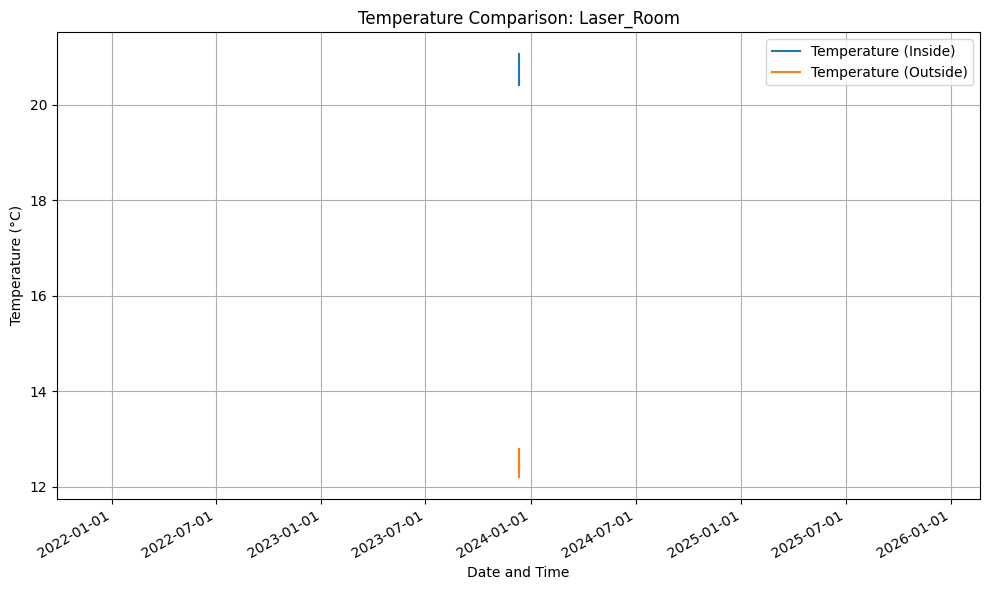

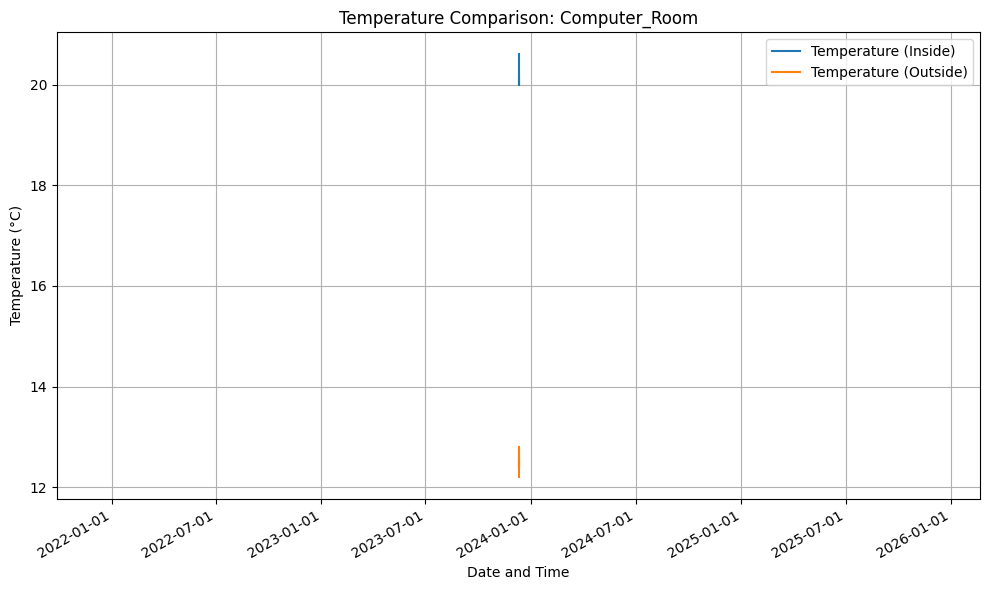

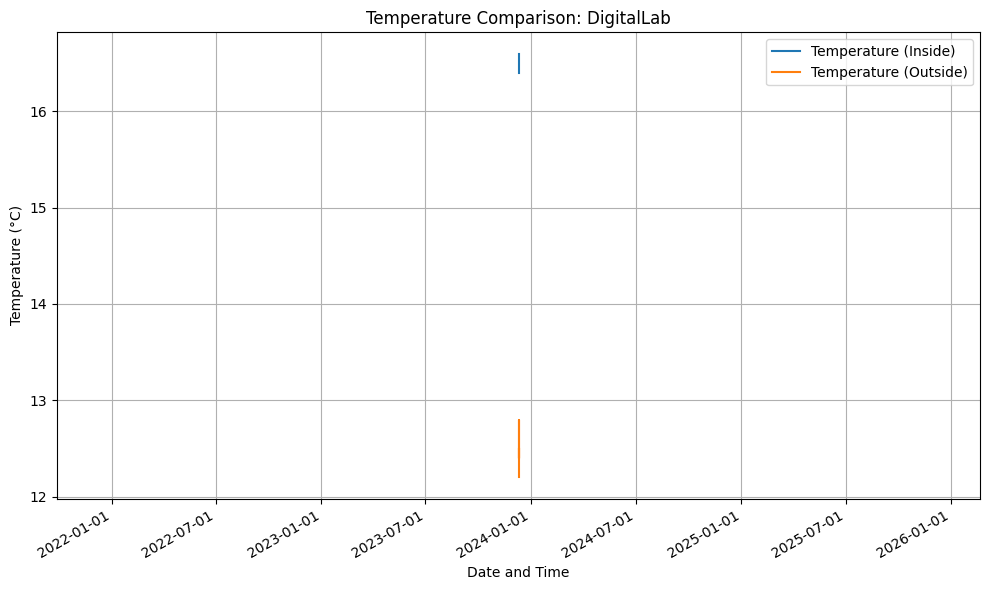

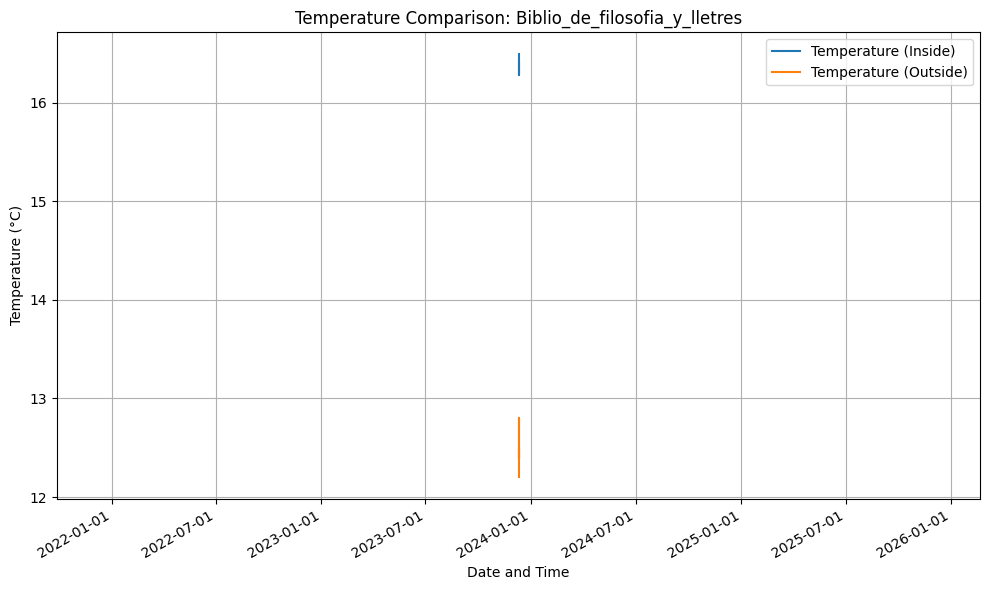

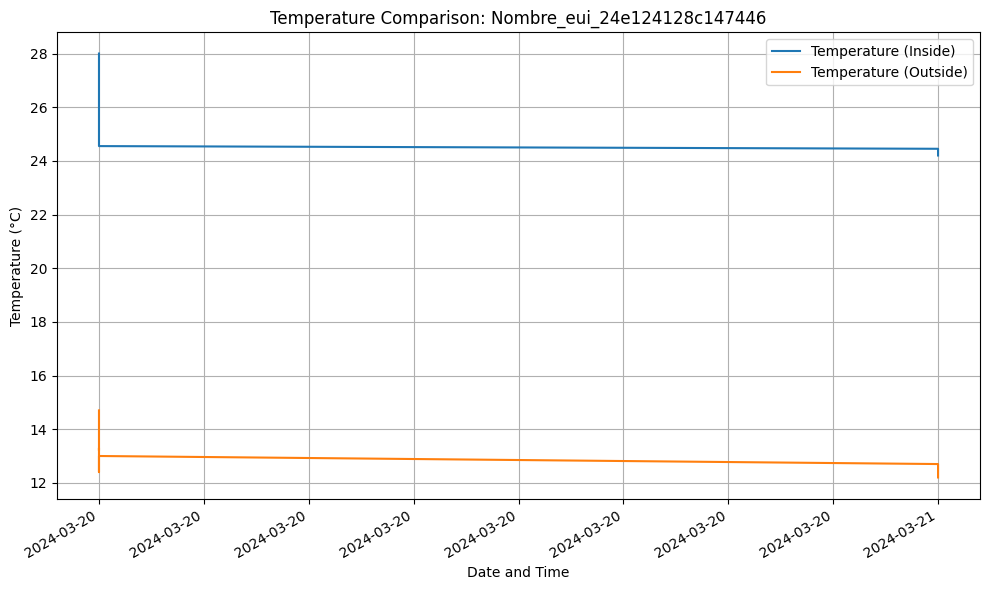

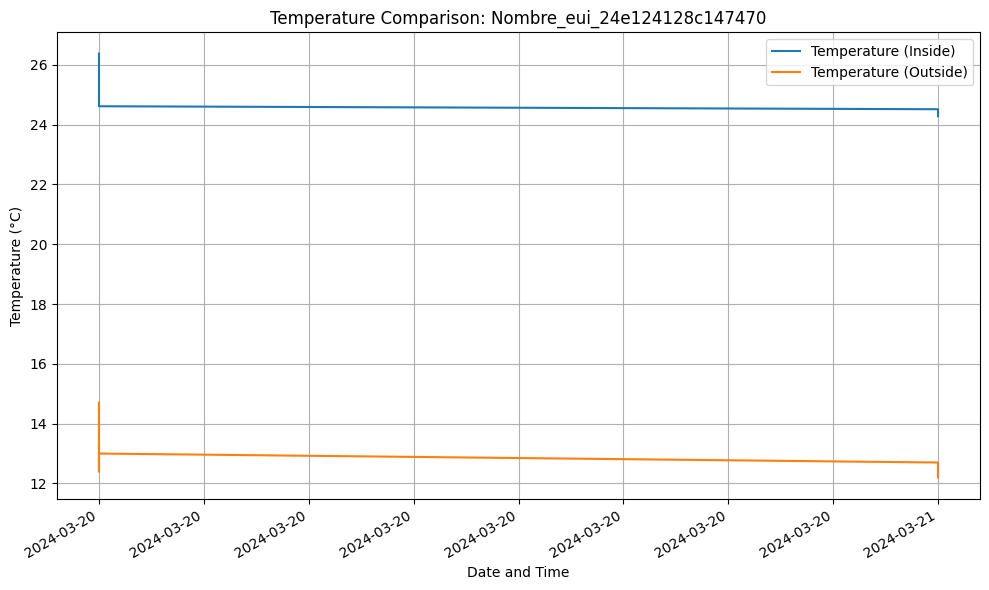

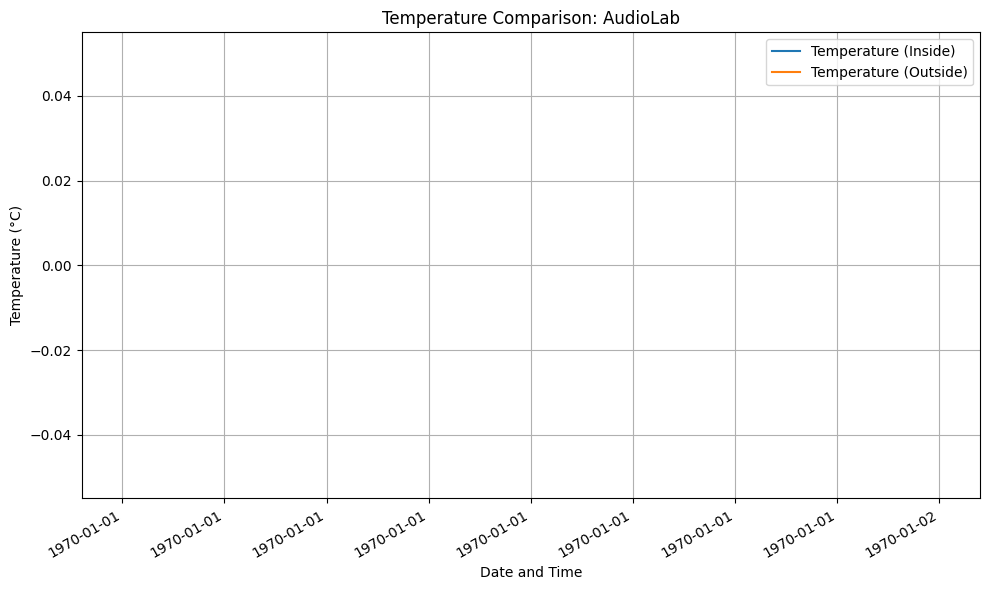

In [50]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Recorrer cada conjunto de datos fusionado en merged_datasets
for name, data in merged_datasets.items():
    # Crear una nueva figura
    plt.figure(figsize=(10, 6))

    # Seleccionar solo un subconjunto de fechas para mostrar (por ejemplo, las primeras 10 fechas)
    subset_data = data.iloc[:10]

    # Graficar la temperatura interior y exterior
    plt.plot(subset_data['date'], subset_data['inside_temperature'], label='Temperature (Inside)')
    plt.plot(subset_data['date'], subset_data['outside_temperature'], label='Temperature (Outside)')

    # Configurar etiquetas y título
    plt.xlabel('Date and Time')
    plt.ylabel('Temperature (°C)')
    plt.title(f'Temperature Comparison: {name}')

    # Rotar las etiquetas del eje x para que sean legibles
    plt.xticks(rotation=45)

    # Formatear las etiquetas del eje x para incluir solo la fecha
    date_format = DateFormatter("%Y-%m-%d")
    plt.gca().xaxis.set_major_formatter(date_format)

    # Ajustar el espaciado entre las etiquetas del eje x
    plt.gcf().autofmt_xdate()

    # Agregar leyenda
    plt.legend()

    # Mostrar la gráfica
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [56]:
# Seleccionar solo las columnas necesarias para construir la tabla
data_to_pivot = merged_datasets['Laser_Room'][['date', 'hour', 'outside_temperature']]

# Pivotar los datos para tener las horas como columnas
pivot_table = data_to_pivot.pivot(index='date', columns='hour', values='outside_temperature')

# Imprimir la tabla
print(pivot_table)

# Buscar los valores NaN en la tabla pivotada
nan_locations = pivot_table.isna()

# Filtrar la tabla pivotada para mostrar solo los valores True (NaN)
nan_locations = pivot_table[pivot_table.isna()]

# Imprimir los NaN
print(nan_locations)



hour        00:00:00  01:00:00  02:00:00  03:00:00  04:00:00  05:00:00  \
date                                                                     
2023-12-10       NaN       NaN      12.4      12.5      12.4      12.4   
2023-12-11      14.0      13.7      13.4      13.1      12.8      12.5   
2023-12-12      15.6      15.5      15.3      15.3      15.2      15.3   
2023-12-13      15.7      15.5      15.4      15.0      15.1      15.3   
2023-12-14      10.3      10.0      10.2       9.7       9.7       9.4   
...              ...       ...       ...       ...       ...       ...   
2024-03-26       9.9       9.9      10.0      10.1      10.2      10.5   
2024-03-27      10.0       8.9       8.8       8.5       8.2       8.4   
2024-03-28       NaN       NaN       NaN       NaN       NaN       NaN   
2024-03-29      14.1      13.2      13.8      13.6      12.6      13.3   
2024-03-30      15.2      12.0      13.2      13.3      13.3      13.7   

hour        06:00:00  07:00:00  08:00

In [58]:
# Suponiendo que "Laser_Room" es tu DataFrame de Pandas
laser_room_data = merged_datasets['Laser_Room']
laser_room_data.to_csv('Laser_Room_dataset.csv', index=False)


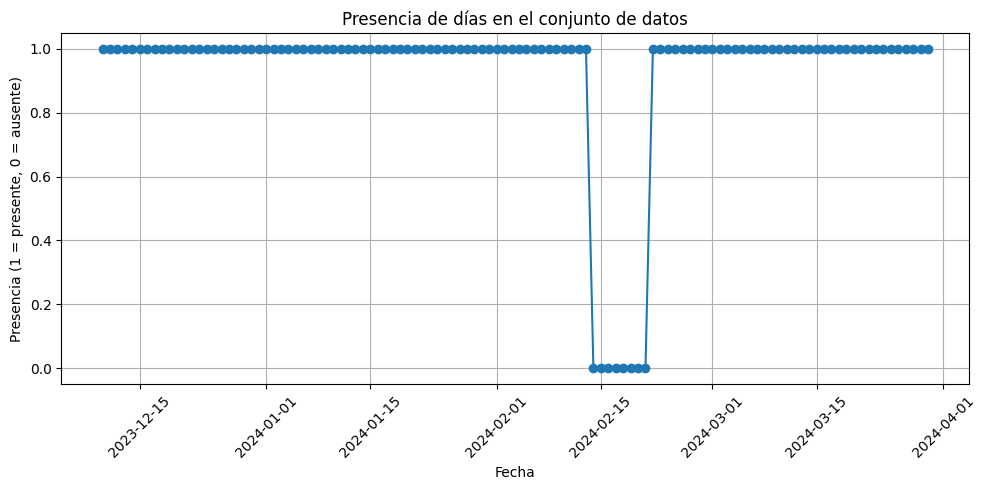

In [59]:
import matplotlib.pyplot as plt
import pandas as pd

# Obtener el rango de fechas del conjunto de datos
start_date = merged_datasets['Laser_Room']['date'].min()
end_date = merged_datasets['Laser_Room']['date'].max()

# Crear una lista de días dentro de ese rango
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Verificar si cada día está presente en el conjunto de datos
presence = [1 if date in merged_datasets['Laser_Room']['date'].unique() else 0 for date in date_range]

# Crear el gráfico
plt.figure(figsize=(10, 5))
plt.plot(date_range, presence, marker='o', linestyle='-')
plt.title('Presencia de días en el conjunto de datos')
plt.xlabel('Fecha')
plt.ylabel('Presencia (1 = presente, 0 = ausente)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


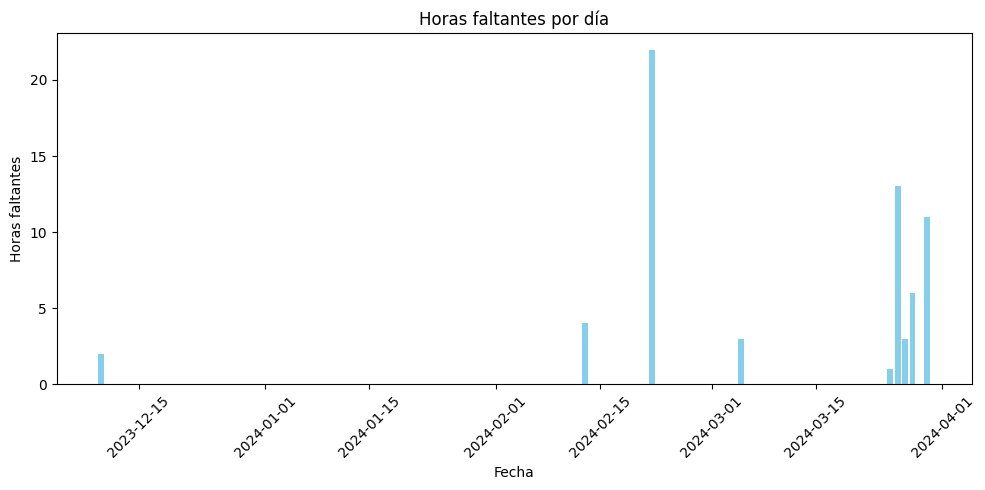

In [63]:
import pandas as pd

# Obtener el conjunto de datos Laser_Room
data = merged_datasets['Laser_Room']

# Convertir la columna 'date' a tipo datetime
data['date'] = pd.to_datetime(data['date'])

# Crear una nueva columna 'datetime' combinando 'date' y 'hour'
data['datetime'] = data.apply(lambda row: pd.Timestamp.combine(row['date'], row['hour']), axis=1)

# Obtener las fechas únicas del conjunto de datos
dates = data['date'].unique()

# Calcular las horas totales en un día
total_hours_per_day = 24

# Inicializar una lista para almacenar la cantidad de horas faltantes por día
missing_hours_per_day = []

# Verificar las horas faltantes para cada día
for date in dates:
    # Filtrar el conjunto de datos por fecha
    day_data = data[data['date'] == date]

    # Obtener las horas únicas en el día
    unique_hours = day_data['hour'].unique()

    # Contar las horas faltantes
    missing_hours = total_hours_per_day - len(unique_hours)
    missing_hours_per_day.append(missing_hours)

# Crear el gráfico
plt.figure(figsize=(10, 5))
plt.bar(dates, missing_hours_per_day, color='skyblue')
plt.title('Horas faltantes por día')
plt.xlabel('Fecha')
plt.ylabel('Horas faltantes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


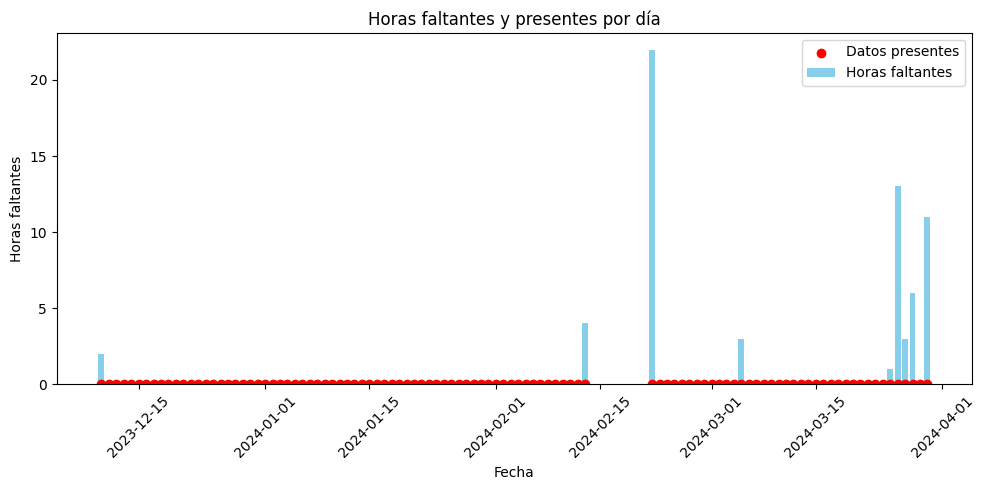

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Obtener el conjunto de datos Laser_Room
data = merged_datasets['Laser_Room']

# Convertir la columna 'date' a tipo datetime
data['date'] = pd.to_datetime(data['date'])

# Crear una nueva columna 'datetime' combinando 'date' y 'hour'
data['datetime'] = data.apply(lambda row: pd.Timestamp.combine(row['date'], row['hour']), axis=1)

# Obtener las fechas únicas del conjunto de datos
dates = data['date'].unique()

# Calcular las horas totales en un día
total_hours_per_day = 24

# Inicializar una lista para almacenar la cantidad de horas faltantes por día
missing_hours_per_day = []

# Verificar las horas faltantes para cada día
for date in dates:
    # Filtrar el conjunto de datos por fecha
    day_data = data[data['date'] == date]

    # Obtener las horas únicas en el día
    unique_hours = day_data['hour'].unique()

    # Contar las horas faltantes
    missing_hours = total_hours_per_day - len(unique_hours)
    missing_hours_per_day.append(missing_hours)

# Crear el gráfico de barras para las horas faltantes
plt.figure(figsize=(10, 5))
plt.bar(dates, missing_hours_per_day, color='skyblue', label='Horas faltantes')
plt.title('Horas faltantes y presentes por día')
plt.xlabel('Fecha')
plt.ylabel('Horas faltantes')
plt.xticks(rotation=45)
plt.legend()

# Crear el gráfico de puntos para las fechas con datos
plt.scatter(dates, [0]*len(dates), color='red', marker='o', label='Datos presentes')
plt.legend()

plt.tight_layout()
plt.show()


## Forecasting

Now we have a dictionary called **merged_datasets** with the datasets of the different locations, to acces them we have to use their name:
- Laser_Room *(2431 rows)*
- Computer_Room *(2312 rows)*
- DigitalLab (2441 rows)
- Biblio_de_filosofia_y_lletres *(812 rows)*
- Nombre_eui_24e124128c147446 *(227 rows)*
- Nombre_eui_24e124128c147470 *(227 rows)*
- AudioLab *(0 rows)*


In [43]:
# Seleccionar el dataset Laser_Room
laser_room_data = merged_datasets['Laser_Room']

# Seleccionar características y variable objetivo
X = laser_room_data[['co2', 'humidity', 'outside_temperature']]
y = laser_room_data['inside_temperature']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el modelo de regresión lineal
model = LinearRegression()

# Listas para almacenar la pérdida durante el entrenamiento
train_loss = []
test_loss = []

# Entrenamiento del modelo
model.fit(X_train, y_train)

# Predicciones en el conjunto de entrenamiento y cálculo de la pérdida
train_predictions = model.predict(X_train)
train_mse = mean_squared_error(y_train, train_predictions)
train_loss.append(train_mse)

# Predicciones en el conjunto de prueba y cálculo de la pérdida
test_predictions = model.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)
test_loss.append(test_mse)

print("Train Loss:", train_loss)
print("Test Loss:", test_loss)


Train Loss: [3.024200121326131]
Test Loss: [3.6234709913462493]
